In [1]:
import re
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# # Set pandas options to display all columns and rows
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_rows', None)     # Show all rows

In [5]:
file = f'TOR330 Data/TOR330_2023_aid_stations.xlsx'
pivoted_TOR330_dates = pd.read_excel(file)


### Reading in TORX dates extracted from DUV

In [6]:
file = f'Database Data/TORX_duv_dates_df.xlsx'
dates_duv_df = pd.read_excel(file)

# Drop the intermediate columns if they're no longer needed
dates_duv_df = dates_duv_df.drop(columns=['Day_of_Week Start_Date'])    
dates_duv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Race        26 non-null     object        
 1   Year        26 non-null     int64         
 2   Start Date  26 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 752.0+ bytes


In [34]:
dates_duv_df[(dates_duv_df['Race'] == 'TOR330') &
             (dates_duv_df['Year'].isin([2021, 2022, 2023, 2024]))
            ].sort_values(by = 'Year', ascending = False).reset_index(drop = True)

,Race,Year,Start Date
0,TOR330,2024,2024-09-08 10:00:00
1,TOR330,2023,2023-09-10 10:00:00
2,TOR330,2022,2022-09-11 10:00:00
3,TOR330,2021,2021-09-12 10:00:00


In [7]:
# Extract only the date part (YYYY-MM-DD)
TOR450_dates_duv_df = dates_duv_df[(dates_duv_df['Race'] == 'TOR450')]
TOR450_dates_duv_df['Start Date'] = TOR450_dates_duv_df['Start Date'].astype('str')
TOR450_dates_duv_df['Start Date'] = TOR450_dates_duv_df['Start Date'].str.split(' ').str.get(0)

TOR450_dates_duv_df['Start Date'] = TOR450_dates_duv_df['Start Date'].astype('datetime64[D]')


# renaming columns so it is easier later to compare
TOR450_dates_duv_df = TOR450_dates_duv_df.rename(columns={"Start Date": "D1"}) 

TOR450_dates_duv_df['D2'] = TOR450_dates_duv_df['D1'] + pd.to_timedelta('1 day')
TOR450_dates_duv_df['D3'] = TOR450_dates_duv_df['D1'] + pd.to_timedelta('2 days')
TOR450_dates_duv_df['D4'] = TOR450_dates_duv_df['D1'] + pd.to_timedelta('3 days')
TOR450_dates_duv_df['D5'] = TOR450_dates_duv_df['D1'] + pd.to_timedelta('4 days')
TOR450_dates_duv_df['D6'] = TOR450_dates_duv_df['D1'] + pd.to_timedelta('5 days')
TOR450_dates_duv_df['D7'] = TOR450_dates_duv_df['D1'] + pd.to_timedelta('6 days')
TOR450_dates_duv_df['D8'] = TOR450_dates_duv_df['D1'] + pd.to_timedelta('7 days')
TOR450_dates_duv_df['D9'] = TOR450_dates_duv_df['D1'] + pd.to_timedelta('8 days')
TOR450_dates_duv_df['D10'] = TOR450_dates_duv_df['D1'] + pd.to_timedelta('9 days')


C:\Users\Karina\AppData\Local\Temp\ipykernel_11136\3625577159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TOR450_dates_duv_df['Start Date'] = TOR450_dates_duv_df['Start Date'].astype('str')
C:\Users\Karina\AppData\Local\Temp\ipykernel_11136\3625577159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TOR450_dates_duv_df['Start Date'] = TOR450_dates_duv_df['Start Date'].str.split(' ').str.get(0)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11136\3625577159.py:6: SettingWithCopyWarning: 
A value is 

### Getting dates into CutOffs
but the issue is also D3 looks different every year. So using DUV_dates, I am able to extract the date of the TOR450 (which is D1) and then create a new dataset with each D# to get the correct date for each cut off!

In [27]:
# D# | Date | Year
# D1 | '2023-09-08' | 2023


# Pivot the data using melt
pivoted_TOR450_dates_duv_df = TOR450_dates_duv_df.melt(id_vars=["Race", "Year"], 
                     var_name="D#", 
                     value_name="Date")

# Convert 'Date' to datetime and extract just the date (optional)
pivoted_TOR450_dates_duv_df["Date"] = pd.to_datetime(pivoted_TOR450_dates_duv_df["Date"]).dt.date
pivoted_TOR450_dates_duv_df = pivoted_TOR450_dates_duv_df.drop(columns=['Race'])

# Display the result
pivoted_TOR450_dates_duv_df[pivoted_TOR450_dates_duv_df['Year'] == 2023].reset_index(drop = True)

,Year,D#,Date
0,2023,D1,2023-09-08
1,2023,D2,2023-09-09
2,2023,D3,2023-09-10
3,2023,D4,2023-09-11
4,2023,D5,2023-09-12
5,2023,D6,2023-09-13
6,2023,D7,2023-09-14
7,2023,D8,2023-09-15
8,2023,D9,2023-09-16
9,2023,D10,2023-09-17


### Reading in TOR330 Data on elevation / distance

A copy of the original 'TOR330 - Downloads.xlsx' and 'TOR450 - Downloads.xlsx' and were changed to reflect the downloaded 100x100trail data 


The original Timetable looks like this:
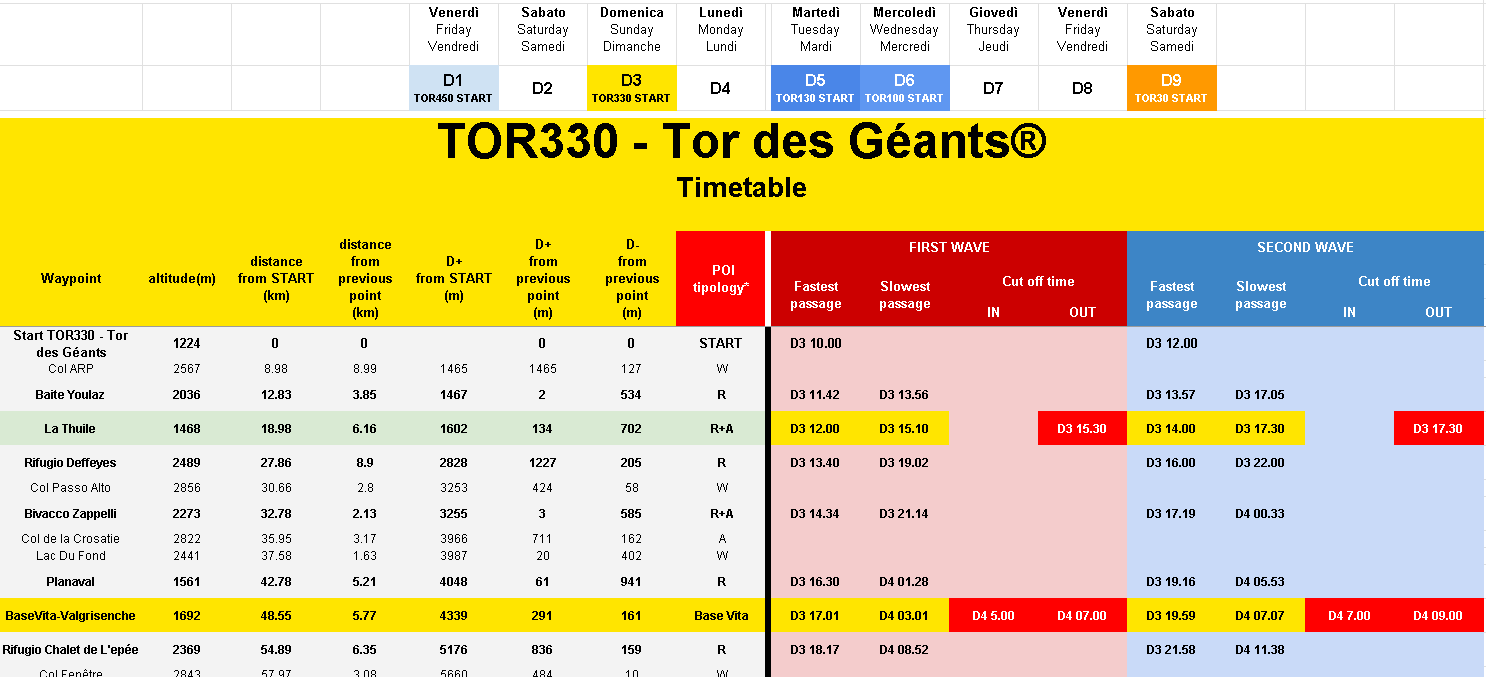

So I cleaned it up by doing this:
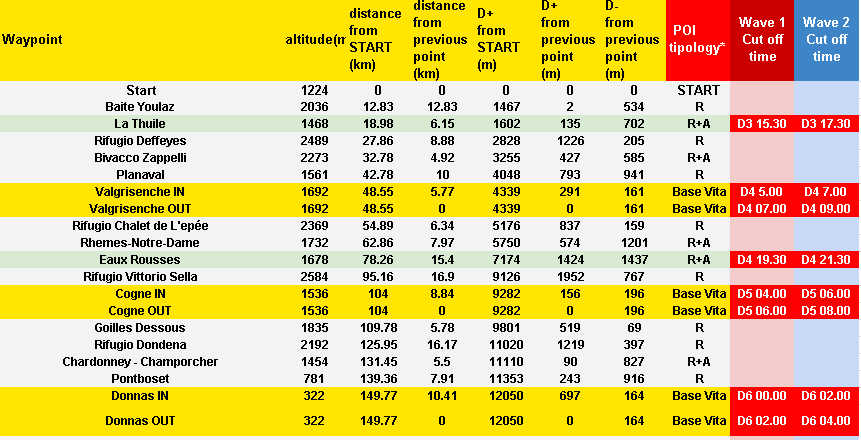

In [9]:
TOR330_aid_station_info_df = pd.read_excel('TOR330 Data/TOR330 - Timetable.xlsx', sheet_name = 'Sheet1')

# organising the data in the correct order by 'distance\nfrom START\n(km)'
TOR330_aid_station_info_df = TOR330_aid_station_info_df.sort_values(by ='distance\nfrom START\n(km)')

# getting the list of aid stations
TOR330_aid_station_list= list(TOR330_aid_station_info_df['100X100trail Aid Stations'].unique())

# the aid station is the correct order
TOR330_aid_station_list


['START',
 'Baite Youlaz',
 'La Thuile',
 'Rifugio Deffeyes',
 'Bivacco Zappelli',
 'Planaval',
 'Valgrisenche IN',
 'Valgrisenche OUT',
 'Chalet Epee',
 'Rhemes-Notre-Dame',
 'Eaux Rousse',
 'Rifugio Sella',
 'Cogne OUT',
 'Cogne IN',
 'Goilles',
 'Rifugio Dondena',
 'Chardonney',
 'Pontboset',
 'Donnas IN',
 'Donnas OUT',
 'Perloz',
 'Sassa',
 'Rifugio Coda',
 'Rifugio della Barma',
 'Lago Chiaro',
 'Col della Vecchia',
 'Niel La Gruba',
 'Loo',
 'Gressoney IN',
 'Gressoney OUT',
 'Rifugio Alpenzu',
 'Champoluc',
 'Rifugio Grand Tournalin',
 'Valtournenche IN',
 'Valtournenche OUT',
 'Rifugio Barmasse',
 'Vareton',
 'Rifugio Magià',
 'Rifugio Cuney',
 'Bivacco R. Clermont',
 'Oyace IN',
 'Bruson Arp',
 'Col Brison',
 'Berio Damon',
 'Ollomont IN',
 'Ollomont OUT',
 'Rifugio Champillon',
 'Ponteille Desot',
 'Bosses',
 'Rifugio Frassati',
 'Pas Entre Deux Sauts',
 'Monte de la Saxe',
 'FINISH']

In [10]:
# keeping only the rows that are not empty
cutoffs_df = TOR330_aid_station_info_df[['Waypoint','Wave 1 Cut off time']][~(TOR330_aid_station_info_df['Wave 1 Cut off time'].isna()) &
                                                                            (TOR330_aid_station_info_df['Wave 1 Cut off time'] != 'MID-RACE')
                                                                           ]

# Splitting 'D# Time'
cutoffs_df['Wave 1 Cut off Split'] = cutoffs_df['Wave 1 Cut off time'].str.split(' ')

# getting the D#
cutoffs_df['D#'] = cutoffs_df['Wave 1 Cut off Split'].str.get(0)
# getting the cut off time
cutoffs_df['D# Time'] = cutoffs_df['Wave 1 Cut off Split'].str.get(1)
# Replacing  'D3 15.30' with 'D3 15:30'
cutoffs_df['D# Time'] = cutoffs_df['D# Time'].str.replace('.', ':')

C:\Users\Karina\AppData\Local\Temp\ipykernel_11136\2254623044.py:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  cutoffs_df['D# Time'] = cutoffs_df['D# Time'].str.replace('.', ':')


### Merging new D# Dataset

In [11]:

# Merging the new D1  dataframe and pivoted_TOR450_dates_duv_df
cutoffs_df = cutoffs_df.merge(
    pivoted_TOR450_dates_duv_df, 
    on='D#',
    how='left')

# getting the date and the time back together
cutoffs_df['new_Wave 1 Cut off time'] = cutoffs_df['Date'].astype('str') + ' ' + cutoffs_df['D# Time']
# convert the new column in datetime 
cutoffs_df['Wave1'] = pd.to_datetime(cutoffs_df['new_Wave 1 Cut off time'])
# Create a new wave2 which is 2 hours behind
cutoffs_df['Wave2'] = cutoffs_df['Wave1'] + pd.to_timedelta('02:00:00')
#dropping irrelevant columns
cutoffs_df = cutoffs_df[['Waypoint', 'Year', #'Date',
                         'Wave1', 'Wave2']]
# Pivot the data using melt
cutoffs_df = cutoffs_df.melt(id_vars=['Waypoint',	'Year'], 
                     var_name="Wave", 
                     value_name="Date")

# renaming columns so it is easier later to compare
cutoffs_df = cutoffs_df.rename(columns={"Waypoint": "aid_stations"}) 
# beacuse it will be merged with the main dataset, naming could be issue 
# so renaming to know it is cut off!
cutoffs_df['aid_stations'] =  'Cut Off | ' + cutoffs_df['aid_stations'] 



In [21]:
# Pivot the data so that each aid station has own column
cutoffs_df_pivot = cutoffs_df.pivot_table(
    index=['Wave', 'Year'],
    columns='aid_stations',  
    values='Date',
    aggfunc='first'  # Ensures only the first match is kept in case of duplicates
).reset_index()

# reordering cut offs
cutoffs_df_pivot = cutoffs_df_pivot[['Wave', 'Year',
                    'Cut Off | La Thuile',
                    'Cut Off | Valgrisenche IN', 
                    'Cut Off | Valgrisenche OUT',
                    'Cut Off | Eaux Rousses',
                    'Cut Off | Cogne IN', 
                    'Cut Off | Cogne OUT', 
                    'Cut Off | Donnas IN', 
                    'Cut Off | Donnas OUT',
                    'Cut Off | Rifugio Del Lago Della Barma', 
                    'Cut Off | Niel - Dortoir La Gruba',
                    'Cut Off | Gressoney IN', 
                    'Cut Off | Gressoney OUT',
                    'Cut Off | Champoluc', 
                    'Cut Off | Valtournenche IN', 
                    'Cut Off | Valtournenche OUT',    
                    'Cut Off | Oyace',
                    'Cut Off | Ollomont IN', 
                    'Cut Off | Ollomont OUT', 
                    'Cut Off | TORX Finish Line']]

# renaming columns so it is easier later to compare
cutoffs_df_pivot = cutoffs_df_pivot.rename(columns={
    "Cut Off | Eaux Rousses": "Cut Off | Eaux Rousse",
    "Cut Off | Rifugio Del Lago Della Barma": "Cut Off | Rifugio della Barma",
    "Cut Off | Niel - Dortoir La Gruba": "Cut Off | Niel La Gruba",
    "Cut Off | Oyace": "Cut Off | Oyace IN",
    "Cut Off | TORX Finish Line": "Cut Off | FINISH"})

cutoffs_df_pivot['Year'] = cutoffs_df_pivot['Year'].astype('str')

# showing a example of cutoffs_df_pivot
cutoffs_df_pivot[cutoffs_df_pivot['Year'] == '2023'].head()

aid_stations,Wave,Year,Cut Off | La Thuile,Cut Off | Valgrisenche IN,Cut Off | Valgrisenche OUT,Cut Off | Eaux Rousse,Cut Off | Cogne IN,Cut Off | Cogne OUT,Cut Off | Donnas IN,Cut Off | Donnas OUT,...,Cut Off | Niel La Gruba,Cut Off | Gressoney IN,Cut Off | Gressoney OUT,Cut Off | Champoluc,Cut Off | Valtournenche IN,Cut Off | Valtournenche OUT,Cut Off | Oyace IN,Cut Off | Ollomont IN,Cut Off | Ollomont OUT,Cut Off | FINISH
3,Wave1,2023,2023-09-10 15:30:00,2023-09-11 05:00:00,2023-09-11 07:00:00,2023-09-11 19:30:00,2023-09-12 04:00:00,2023-09-12 06:00:00,2023-09-13 00:00:00,2023-09-13 02:00:00,...,2023-09-13 19:30:00,2023-09-13 23:00:00,2023-09-14 01:00:00,2023-09-14 13:00:00,2023-09-14 19:00:00,2023-09-14 21:00:00,2023-09-15 12:00:00,2023-09-15 17:00:00,2023-09-15 19:00:00,2023-09-16 16:00:00
8,Wave2,2023,2023-09-10 17:30:00,2023-09-11 07:00:00,2023-09-11 09:00:00,2023-09-11 21:30:00,2023-09-12 06:00:00,2023-09-12 08:00:00,2023-09-13 02:00:00,2023-09-13 04:00:00,...,2023-09-13 21:30:00,2023-09-14 01:00:00,2023-09-14 03:00:00,2023-09-14 15:00:00,2023-09-14 21:00:00,2023-09-14 23:00:00,2023-09-15 14:00:00,2023-09-15 19:00:00,2023-09-15 21:00:00,2023-09-16 18:00:00


### Adding Cut off Times

In [23]:
cutoffs_df_pivot_2023 = cutoffs_df_pivot[cutoffs_df_pivot['Year'] == '2023']
cutoffs_df_pivot_2023


aid_stations,Wave,Year,Cut Off | La Thuile,Cut Off | Valgrisenche IN,Cut Off | Valgrisenche OUT,Cut Off | Eaux Rousse,Cut Off | Cogne IN,Cut Off | Cogne OUT,Cut Off | Donnas IN,Cut Off | Donnas OUT,...,Cut Off | Niel La Gruba,Cut Off | Gressoney IN,Cut Off | Gressoney OUT,Cut Off | Champoluc,Cut Off | Valtournenche IN,Cut Off | Valtournenche OUT,Cut Off | Oyace IN,Cut Off | Ollomont IN,Cut Off | Ollomont OUT,Cut Off | FINISH
3,Wave1,2023,2023-09-10 15:30:00,2023-09-11 05:00:00,2023-09-11 07:00:00,2023-09-11 19:30:00,2023-09-12 04:00:00,2023-09-12 06:00:00,2023-09-13 00:00:00,2023-09-13 02:00:00,...,2023-09-13 19:30:00,2023-09-13 23:00:00,2023-09-14 01:00:00,2023-09-14 13:00:00,2023-09-14 19:00:00,2023-09-14 21:00:00,2023-09-15 12:00:00,2023-09-15 17:00:00,2023-09-15 19:00:00,2023-09-16 16:00:00
8,Wave2,2023,2023-09-10 17:30:00,2023-09-11 07:00:00,2023-09-11 09:00:00,2023-09-11 21:30:00,2023-09-12 06:00:00,2023-09-12 08:00:00,2023-09-13 02:00:00,2023-09-13 04:00:00,...,2023-09-13 21:30:00,2023-09-14 01:00:00,2023-09-14 03:00:00,2023-09-14 15:00:00,2023-09-14 21:00:00,2023-09-14 23:00:00,2023-09-15 14:00:00,2023-09-15 19:00:00,2023-09-15 21:00:00,2023-09-16 18:00:00


### Check the year as int or str!

In [26]:
# Merging the new D1  dataframe and pivoted_TOR450_dates_duv_df
TORX_pivot_cutoffs = pivoted_TOR330_dates.merge(
    cutoffs_df_pivot_2023, 
    on=['Year', 'Wave'],
    how='left'
)

TORX_pivot_cutoffs.head()

ValueError: You are trying to merge on int64 and object columns. If you wish to proceed you should use pd.concat

In [25]:
for column in [

 'La Thuile',
       'Valgrisenche IN', 'Valgrisenche OUT',
       'Eaux Rousse', 'Cogne IN', 'Cogne OUT',
       'Donnas IN', 'Donnas OUT',
       'Rifugio della Barma', 'Niel La Gruba',
       'Gressoney IN', 'Gressoney OUT',
       'Champoluc', 'Valtournenche IN',
       'Valtournenche OUT', 'Oyace IN',
       'Ollomont IN', 'Ollomont OUT', 'FINISH'
]:
    
    new_column = f'Cut Off | {column}'
    
    try:
        TORX_pivot_cutoffs[f'NEW_Calculations Cut Off | {column}'] = TORX_pivot_cutoffs[column] -TORX_pivot_DNF_cutoffs[new_column]
    except:
        print('Issues:','\n', '\t', column, '\n', '\t',new_column)


Issues: 
 	 La Thuile 
 	 Cut Off | La Thuile
Issues: 
 	 Valgrisenche IN 
 	 Cut Off | Valgrisenche IN
Issues: 
 	 Valgrisenche OUT 
 	 Cut Off | Valgrisenche OUT
Issues: 
 	 Eaux Rousse 
 	 Cut Off | Eaux Rousse
Issues: 
 	 Cogne IN 
 	 Cut Off | Cogne IN
Issues: 
 	 Cogne OUT 
 	 Cut Off | Cogne OUT
Issues: 
 	 Donnas IN 
 	 Cut Off | Donnas IN
Issues: 
 	 Donnas OUT 
 	 Cut Off | Donnas OUT
Issues: 
 	 Rifugio della Barma 
 	 Cut Off | Rifugio della Barma
Issues: 
 	 Niel La Gruba 
 	 Cut Off | Niel La Gruba
Issues: 
 	 Gressoney IN 
 	 Cut Off | Gressoney IN
Issues: 
 	 Gressoney OUT 
 	 Cut Off | Gressoney OUT
Issues: 
 	 Champoluc 
 	 Cut Off | Champoluc
Issues: 
 	 Valtournenche IN 
 	 Cut Off | Valtournenche IN
Issues: 
 	 Valtournenche OUT 
 	 Cut Off | Valtournenche OUT
Issues: 
 	 Oyace IN 
 	 Cut Off | Oyace IN
Issues: 
 	 Ollomont IN 
 	 Cut Off | Ollomont IN
Issues: 
 	 Ollomont OUT 
 	 Cut Off | Ollomont OUT
Issues: 
 	 FINISH 
 	 Cut Off | FINISH


In [ ]:

for column in [

 'La Thuile',
       'Valgrisenche IN', 'Valgrisenche OUT',
       'Eaux Rousse', 'Cogne IN', 'Cogne OUT',
       'Donnas IN', 'Donnas OUT',
       'Rifugio della Barma', 'Niel La Gruba',
       'Gressoney IN', 'Gressoney OUT',
       'Champoluc', 'Valtournenche IN',
       'Valtournenche OUT', 'Oyace IN',
       'Ollomont IN', 'Ollomont OUT', 'FINISH'
]:
    print(column.upper(), '\n', TORX_pivot_DNF_cutoffs[['Name', 'Wave', 'Gressoney IN' , column,
                       f'Cut Off | {column}',
                       f'NEW_Calculations Cut Off | {column}', 'Retired']][
    TORX_pivot_DNF_cutoffs[f'NEW_Calculations Cut Off | {column}'] > pd.to_timedelta('00:00:00')])

In [ ]:
TORX_pivot_DNF_cutoffs[TORX_pivot_DNF_cutoffs['Name'] == 'Bellucci Laurent']

In [ ]:
### Adding Cut off Times

cutoffs_df_pivot_2023 = cutoffs_df_pivot[cutoffs_df_pivot['Year'] == '2023']
cutoffs_df_pivot_2023


# Merging the new D1  dataframe and pivoted_TOR450_dates_duv_df
TORX_pivot_DNF_cutoffs = pivot_DNF.merge(
    cutoffs_df_pivot_2023, 
    on=['Year', 'Wave'],
    how='left'
)









In [ ]:
TORX_pivot_DNF_cutoffs.head()


In [ ]:
for column in [

 'La Thuile',
       'Valgrisenche IN', 'Valgrisenche OUT',
       'Eaux Rousse', 'Cogne IN', 'Cogne OUT',
       'Donnas IN', 'Donnas OUT',
       'Rifugio della Barma', 'Niel La Gruba',
       'Gressoney IN', 'Gressoney OUT',
       'Champoluc', 'Valtournenche IN',
       'Valtournenche OUT', 'Oyace IN',
       'Ollomont IN', 'Ollomont OUT', 'FINISH'
]:
    
    new_column = f'Cut Off | {column}'
    
    try:
        TORX_pivot_DNF_cutoffs[f'NEW_Calculations Cut Off | {column}'] = TORX_pivot_DNF_cutoffs[column] -TORX_pivot_DNF_cutoffs[new_column]
    except:
        print('Issues:','\n', '\t', column, '\n', '\t',new_column)

In [ ]:

for column in [

 'La Thuile',
       'Valgrisenche IN', 'Valgrisenche OUT',
       'Eaux Rousse', 'Cogne IN', 'Cogne OUT',
       'Donnas IN', 'Donnas OUT',
       'Rifugio della Barma', 'Niel La Gruba',
       'Gressoney IN', 'Gressoney OUT',
       'Champoluc', 'Valtournenche IN',
       'Valtournenche OUT', 'Oyace IN',
       'Ollomont IN', 'Ollomont OUT', 'FINISH'
]:
    print(column.upper(), '\n', TORX_pivot_DNF_cutoffs[['Name', 'Wave', 'Gressoney IN' , column,
                       f'Cut Off | {column}',
                       f'NEW_Calculations Cut Off | {column}', 'Retired']][
    TORX_pivot_DNF_cutoffs[f'NEW_Calculations Cut Off | {column}'] > pd.to_timedelta('00:00:00')])


In [ ]:

TORX_pivot_DNF_cutoffs[TORX_pivot_DNF_cutoffs['Name'] == 'Bellucci Laurent']